In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.nn.init as init
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim


!pip install wandb -qqq

import wandb
wandb.login(key ='bf77f5f1c4119e980c1e7dd625ad82a4624f2d94')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

True

### **Data Loader**

In [3]:
from PIL import Image, ImageEnhance, ImageOps
import random
import numpy as np
import torch


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        return img

class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        self.p1 = p1
        self.op1=operation1
        self.magnitude_idx1=magnitude_idx1
        self.p2 = p2
        self.op2=operation2
        self.magnitude_idx2=magnitude_idx2
        self.fillcolor=fillcolor
        self.init = 0

    def gen(self, operation1, magnitude_idx1, operation2, magnitude_idx2, fillcolor):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude *
                                         random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude *
                                         random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude *
                                         img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude *
                                         img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if self.init == 0:
            self.gen(self.op1, self.magnitude_idx1, self.op2, self.magnitude_idx2, self.fillcolor)
            self.init = 1
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """

    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"

class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.

        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """

    def __init__(self, fillcolor=(128, 128, 128), seed=None):
        self.fillcolor = fillcolor
        self.seed = seed
        if self.seed is not None:
            random.seed(self.seed)

        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.8, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        #print(f"policy idx:  {policy_idx}")
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"

In [4]:
def GetCifar10(batchsize):
    trans_t = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  #CIFAR10Policy(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                  Cutout(n_holes=1, length=16)
                                  ])
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    train_data = datasets.CIFAR10('./data', train=True, transform=trans_t, download=True)
    test_data = datasets.CIFAR10('./data', train=False, transform=trans, download=True)
    train_dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=True, num_workers=8)
    test_dataloader = DataLoader(test_data, batch_size=batchsize, shuffle=False, num_workers=8)
    return train_dataloader, test_dataloader

In [5]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(128, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))  # fixed output size
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def make_layers(cfg, batch_norm=False, activation=nn.ReLU):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                if activation in [nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU]:
                    layers += [conv2d, nn.BatchNorm2d(v), activation(inplace=True)]
                else:
                    layers += [conv2d, nn.BatchNorm2d(v), activation()]
            else:
                if activation in [nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU]:
                    layers += [conv2d, activation(inplace=True)]
                else:
                    layers += [conv2d, activation()]
            in_channels = v
    return nn.Sequential(*layers)

def vgg(cfg, num_classes=10, batch_norm=True, activation=nn.GELU):
    return VGG(make_layers(cfg, batch_norm=batch_norm, activation=activation), num_classes=num_classes)

# VGG-6 configuration
cfg_vgg6 = [64, 64, 'M', 128, 128, 'M']

model = vgg(cfg_vgg6, num_classes=10, batch_norm=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): GELU(approximate='none')
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): GELU(approximate='none')
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [6]:
def eval(model,data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    acc = 100. * correct / total
    return acc

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [8]:

def train_model(model,epochs,optimizer,train_loader,test_loader):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()
    for epoch in range(epochs):
      running_loss = 0.0
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          outputs = model(data)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      train_loss = running_loss/len(train_loader)
      train_acc = eval(model,train_loader)
      test_acc = eval(model,test_loader)

      train_losses.append(train_loss)
      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)
      if wandb.run is not None:
          wandb.log({
              "epoch": epoch + 1,
              "train_loss": train_loss,
              "train_accuracy": train_acc,
              "test_accuracy": test_acc
          })

      print(f"Epoch {epoch} - Train_Loss: {train_loss:.4f} , Train_acc: {train_acc}, Test_acc : {test_acc}")

    return train_losses, train_accuracies, test_accuracies

In [ ]:
#train_loader,test_loader = GetCifar10(64)
#model = vgg(cfg_vgg6, num_classes=10, batch_norm=True).to(device)
# criterion = nn.CrossEntropyLoss()
# lr = 0.001
# epochs = 100
# optimizer = optim.Adam(model.parameters(), lr=lr)
# train_model(model,10,optimizer,train_loader,test_loader)

##Task:

    Change the network architecure, activation function , optimizer, learning rate ,etc. and record the performance of the model.

1. Without ciphar10 policy auguementation
 Epoch 8 - Train_Loss: 0.7970 , Train_acc: 74.016, Test_acc : 77.29

 2. With ciphar1 policy

1. a Prepare CIFAR-10 with proper normalization and data augmentation. Specify the
transforms used.

I will use ciphar 10 policy for auguementation

In [9]:
def GetCifar10_policy(batchsize, seed=None):
    trans_t = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  CIFAR10Policy(seed=seed),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                  Cutout(n_holes=1, length=16)
                                  ])
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    train_data = datasets.CIFAR10('./data', train=True, transform=trans_t, download=True)
    test_data = datasets.CIFAR10('./data', train=False, transform=trans, download=True)
    train_dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=True, num_workers=8)
    test_dataloader = DataLoader(test_data, batch_size=batchsize, shuffle=False, num_workers=8)
    return train_dataloader, test_dataloader

In [10]:
train_loader_p,test_loader_p = GetCifar10_policy(64,seed = 20)
criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 20
# Move the model to the device before initializing the optimizer
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

100%|██████████| 170M/170M [00:14<00:00, 11.5MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:

train_losses, train_accuracies, test_accuracies =train_model(model,20,optimizer,train_loader_p,test_loader_p)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 - Train_Loss: 1.5420 , Train_acc: 40.57, Test_acc : 49.21
Epoch 1 - Train_Loss: 1.4979 , Train_acc: 49.766, Test_acc : 60.38
Epoch 2 - Train_Loss: 1.3790 , Train_acc: 53.94, Test_acc : 64.51
Epoch 3 - Train_Loss: 1.3064 , Train_acc: 55.488, Test_acc : 67.86
Epoch 4 - Train_Loss: 1.2491 , Train_acc: 56.912, Test_acc : 67.96
Epoch 5 - Train_Loss: 1.2012 , Train_acc: 59.396, Test_acc : 70.98
Epoch 6 - Train_Loss: 1.1588 , Train_acc: 58.32, Test_acc : 68.76
Epoch 7 - Train_Loss: 1.1261 , Train_acc: 61.346, Test_acc : 73.1
Epoch 8 - Train_Loss: 1.0953 , Train_acc: 61.724, Test_acc : 73.1
Epoch 9 - Train_Loss: 1.0652 , Train_acc: 63.834, Test_acc : 75.58
Epoch 10 - Train_Loss: 1.0474 , Train_acc: 64.348, Test_acc : 75.19
Epoch 11 - Train_Loss: 1.0211 , Train_acc: 65.94, Test_acc : 76.87
Epoch 12 - Train_Loss: 0.9990 , Train_acc: 66.046, Test_acc : 77.74
Epoch 13 - Train_Loss: 0.9939 , Train_acc: 65.62, Test_acc : 76.35
Epoch 14 - Train_Loss: 0.9709 , Train_acc: 66.894, Test_acc : 78.

#1.a From the above improve in accuracy , it becomes apparent how adding data augementation improves accuracy

#1.b Prepared the above model with the following configurations


*   Activation = RELU
*   Optimizer = Adam
*   Epochs = 20
*   seed =20(not really a paramter)
*   learning rate = 0.01

#1.c Top Accuracy : 80 %, graphs below



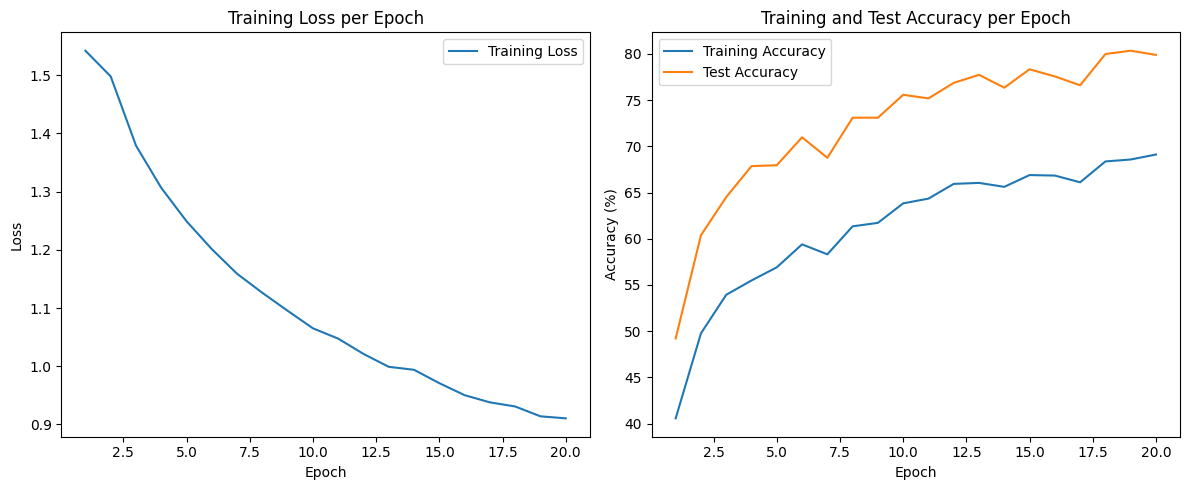

In [15]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, test_accuracies, epochs):
    epochs_list = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_list, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracies, test_accuracies,20)

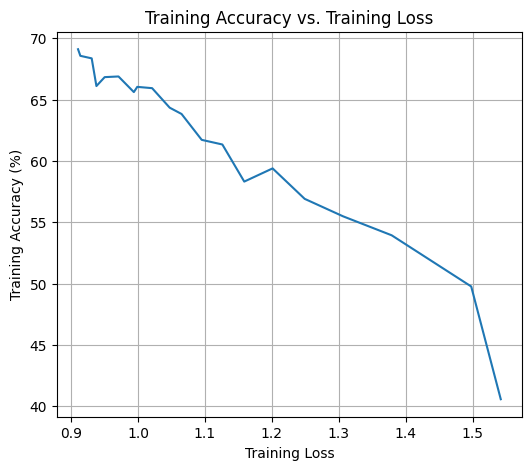

In [16]:
plt.figure(figsize=(6, 5))
plt.plot(train_losses, train_accuracies)
plt.xlabel('Training Loss')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy vs. Training Loss')
plt.grid(True)
plt.show()

#2. Model Performance on Different Configurations


#**(a)** Vary the activation function. Use different activations such as ReLU, Sigmoid, Tanh,

SiLU, GELU, etc. Describe how model performance changes when the activation func-
tion is varied. (20)

#**(b)** Vary the optimizer. Use different optimizers such as SGD, Nesterov-SGD, Adam,
Adagrad, RMSprop, Nadam, etc. Explain how each optimizer affects convergence and
how they differ from one another. (30)


#**(c)** Vary the batch size, number of epochs, and learning rate. Explain how the convergence
speed and performance vary with these changes. (10)

In [17]:
def train_with_activations(activations_list, cfg, num_classes, batch_norm, epochs, train_loader, test_loader, criterion, lr):
    results = {}
    for activation_name, activation_class in activations_list:
        print(f"Training with {activation_name} activation...")
        # Re-initialize the model for each activation
        model = vgg(cfg, num_classes=num_classes, batch_norm=batch_norm, activation=activation_class).to(device)

        # Re-initialize the optimizer for each model
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_losses, train_accuracies, test_accuracies = train_model(model, epochs, optimizer, train_loader, test_loader)
        results[activation_name] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies
        }
        print("-" * 50)
    return results

In [18]:
activations_to_test = [
    ('ReLU', nn.ReLU),
    ('Sigmoid', nn.Sigmoid),
    ('Tanh', nn.Tanh),
    ('SiLU', nn.SiLU),
    ('GELU', nn.GELU)
]

# Assuming you have cfg_vgg6, num_classes, batch_norm, epochs, train_loader_p, test_loader_p, criterion, and lr defined

results_activations = train_with_activations(activations_to_test, cfg_vgg6, 10, True, 10, train_loader_p, test_loader_p, criterion, lr)

Training with ReLU activation...
Epoch 0 - Train_Loss: 1.7997 , Train_acc: 38.936, Test_acc : 49.44
Epoch 1 - Train_Loss: 1.6049 , Train_acc: 46.422, Test_acc : 57.61
Epoch 2 - Train_Loss: 1.4542 , Train_acc: 50.884, Test_acc : 60.83
Epoch 3 - Train_Loss: 1.3660 , Train_acc: 52.996, Test_acc : 63.07
Epoch 4 - Train_Loss: 1.3020 , Train_acc: 56.382, Test_acc : 68.05
Epoch 5 - Train_Loss: 1.2357 , Train_acc: 57.884, Test_acc : 69.34
Epoch 6 - Train_Loss: 1.1782 , Train_acc: 60.524, Test_acc : 72.01
Epoch 7 - Train_Loss: 1.1478 , Train_acc: 59.784, Test_acc : 70.39
Epoch 8 - Train_Loss: 1.1188 , Train_acc: 61.03, Test_acc : 72.95
Epoch 9 - Train_Loss: 1.0795 , Train_acc: 63.08, Test_acc : 73.76
--------------------------------------------------
Training with Sigmoid activation...
Epoch 0 - Train_Loss: 2.0109 , Train_acc: 16.912, Test_acc : 24.42
Epoch 1 - Train_Loss: 2.3513 , Train_acc: 10.0, Test_acc : 10.0
Epoch 2 - Train_Loss: 2.3097 , Train_acc: 10.0, Test_acc : 10.0
Epoch 3 - Train_L

In [ ]:
SGD (Stochastic Gradient Descent): This is the most basic optimizer. It updates the model's parameters based on the gradient of a single randomly selected training example (or a small batch). This can lead to noisy updates, but it can also help escape local minima. Convergence can be slow and oscillate around the minimum.
Nesterov-SGD: This is an improvement over standard SGD. It calculates the gradient not at the current position, but at a position that is a "look ahead" based on the previous update. This helps to build momentum and often leads to faster and more stable convergence by preventing oscillations.
Adam (Adaptive Moment Estimation): Adam is an adaptive learning rate optimization algorithm. It calculates individual adaptive learning rates for different parameters. It uses estimations of both the first and second moments of the gradients. Adam is generally considered robust and often performs well on a wide range of problems. It tends to converge quickly.
Adagrad (Adaptive Gradient Algorithm): Adagrad adapts the learning rate to the parameters, performing larger updates for infrequent parameters and smaller updates for frequent parameters. It works well for sparse data. However, the learning rate can become very small over time, potentially slowing down convergence.
RMSprop (Root Mean Square Propagation): RMSprop is also an adaptive learning rate optimizer. It divides the learning rate by an exponentially decaying average of squared gradients. This helps to address the diminishing learning rates issue of Adagrad. It works well in online and non-stationary settings.
Nadam (Nesterov-accelerated Adaptive Moment Estimation): Nadam combines the ideas of Adam and Nesterov momentum. It uses the adaptive learning rates of Adam but incorporates the Nesterov "look ahead" in the momentum calculation. This often leads to faster convergence and sometimes better performance than Adam.
In summary:

SGD is simple but can be slow and oscillate.
Nesterov-SGD improves SGD with momentum and look-ahead, leading to faster and more stable convergence.
Adaptive optimizers (Adam, Adagrad, RMSprop, Nadam) adjust learning rates per parameter, often leading to faster convergence and better performance, especially on complex datasets.
Adam and Nadam are generally good default choices, combining momentum and adaptive learning rates.
Adagrad is particularly suited for sparse data.
RMSprop is good for online learning and non-stationary objectives.
The best optimizer can depend on the specific dataset, model architecture, and hyperparameters. Experimentation is often needed to find the optimal one.

Vanishing Gradients: The gradient of the Sigmoid function is very small for large positive or negative inputs. During backpropagation, these small gradients are multiplied layer by layer, causing the gradients to shrink exponentially as they flow back to the earlier layers. This makes it difficult for the network to learn the weights in the initial layers, a problem known as vanishing gradients.

#2.b Vary the optimizer
1. SGD
2. Nesterov-SGD
3. Adam
4. Adagrad
5. RMSprop
6. Nadam

In [21]:
def train_with_optimizers(optimizers_list, model, epochs, train_loader, test_loader, criterion, lr):
    results = {}
    for optimizer_name, optimizer_class in optimizers_list:
        print(f"Training with {optimizer_name} optimizer...")
        # Re-initialize the model for each optimizer to start from the same point
        # You might want to load a saved initial state if you need exact reproducibility
        model = vgg(cfg_vgg6, num_classes=10, batch_norm=True,activation = nn.GELU).to(device)
        optimizer = optimizer_class(model.parameters(), lr=lr)

        train_losses, train_accuracies, test_accuracies = train_model(model, epochs, optimizer, train_loader, test_loader)
        results[optimizer_name] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies
        }
        print("-" * 50)
    return results

In [23]:
optimizers_to_test = [
    ('SGD', optim.SGD),
    ('Nesterov-SGD', optim.SGD), # Nesterov momentum can be enabled in SGD
    ('Adam', optim.Adam),
    ('Adagrad', optim.Adagrad),
    ('RMSprop', optim.RMSprop),
    ('Nadam', optim.NAdam) # Nadam is available in recent PyTorch versions
]

# For Nesterov-SGD, we need to specify momentum and nesterov=True
optimizers_to_test[1] = ('Nesterov-SGD', lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9, nesterov=True))


# Assuming you have train_loader_p and test_loader_p from previous steps
# and model, criterion, lr defined
# If not, make sure they are defined before running this cell

results = train_with_optimizers(optimizers_to_test, model, 10, train_loader_p, test_loader_p, criterion, lr)

Training with SGD optimizer...
Epoch 0 - Train_Loss: 2.2718 , Train_acc: 21.614, Test_acc : 27.12
Epoch 1 - Train_Loss: 2.1003 , Train_acc: 25.022, Test_acc : 31.48
Epoch 2 - Train_Loss: 2.0221 , Train_acc: 27.166, Test_acc : 34.92
Epoch 3 - Train_Loss: 1.9749 , Train_acc: 28.42, Test_acc : 35.85
Epoch 4 - Train_Loss: 1.9368 , Train_acc: 27.388, Test_acc : 34.11
Epoch 5 - Train_Loss: 1.9002 , Train_acc: 29.85, Test_acc : 36.37
Epoch 6 - Train_Loss: 1.8685 , Train_acc: 28.296, Test_acc : 42.18
Epoch 7 - Train_Loss: 1.8468 , Train_acc: 31.566, Test_acc : 43.99
Epoch 8 - Train_Loss: 1.8260 , Train_acc: 34.658, Test_acc : 42.93
Epoch 9 - Train_Loss: 1.8030 , Train_acc: 32.488, Test_acc : 40.34
--------------------------------------------------
Training with Nesterov-SGD optimizer...
Epoch 0 - Train_Loss: 2.0303 , Train_acc: 32.096, Test_acc : 37.67
Epoch 1 - Train_Loss: 1.8334 , Train_acc: 35.472, Test_acc : 43.19
Epoch 2 - Train_Loss: 1.7146 , Train_acc: 39.772, Test_acc : 48.23
Epoch 3 -

Training with SGD optimizer
Epoch 0 - Train_Loss: 2.2718 , Train_acc: 21.614, Test_acc : 27.12
Epoch 1 - Train_Loss: 2.1003 , Train_acc: 25.022, Test_acc : 31.48
Epoch 2 - Train_Loss: 2.0221 , Train_acc: 27.166, Test_acc : 34.92
Epoch 3 - Train_Loss: 1.9749 , Train_acc: 28.42, Test_acc : 35.85
Epoch 4 - Train_Loss: 1.9368 , Train_acc: 27.388, Test_acc : 34.11
Epoch 5 - Train_Loss: 1.9002 , Train_acc: 29.85, Test_acc : 36.37
Epoch 6 - Train_Loss: 1.8685 , Train_acc: 28.296, Test_acc : 42.18
Epoch 7 - Train_Loss: 1.8468 , Train_acc: 31.566, Test_acc : 43.99
Epoch 8 - Train_Loss: 1.8260 , Train_acc: 34.658, Test_acc : 42.93
Epoch 9 - Train_Loss: 1.8030 , Train_acc: 32.488, Test_acc : 40.34
--------------------------------------------------
Training with Nesterov-SGD optimizer...
Epoch 0 - Train_Loss: 2.0303 , Train_acc: 32.096, Test_acc : 37.67
Epoch 1 - Train_Loss: 1.8334 , Train_acc: 35.472, Test_acc : 43.19
Epoch 2 - Train_Loss: 1.7146 , Train_acc: 39.772, Test_acc : 48.23
Epoch 3 - Train_Loss: 1.6527 , Train_acc: 41.85, Test_acc : 48.34
Epoch 4 - Train_Loss: 1.5934 , Train_acc: 43.404, Test_acc : 52.37
Epoch 5 - Train_Loss: 1.5529 , Train_acc: 45.676, Test_acc : 55.15
Epoch 6 - Train_Loss: 1.5225 , Train_acc: 45.87, Test_acc : 56.43
Epoch 7 - Train_Loss: 1.4822 , Train_acc: 43.926, Test_acc : 57.58
Epoch 8 - Train_Loss: 1.4467 , Train_acc: 47.81, Test_acc : 57.45
Epoch 9 - Train_Loss: 1.4243 , Train_acc: 50.406, Test_acc : 59.4
--------------------------------------------------
Training with Adam optimizer...
Epoch 0 - Train_Loss: 1.7856 , Train_acc: 41.672, Test_acc : 51.82
Epoch 1 - Train_Loss: 1.5499 , Train_acc: 48.026, Test_acc : 58.57
Epoch 2 - Train_Loss: 1.4018 , Train_acc: 51.85, Test_acc : 61.55
Epoch 3 - Train_Loss: 1.3067 , Train_acc: 56.012, Test_acc : 66.01
Epoch 4 - Train_Loss: 1.2372 , Train_acc: 58.3, Test_acc : 70.1
Epoch 5 - Train_Loss: 1.1839 , Train_acc: 60.12, Test_acc : 72.25
Epoch 6 - Train_Loss: 1.1311 , Train_acc: 61.192, Test_acc : 72.37
Epoch 7 - Train_Loss: 1.0929 , Train_acc: 60.92, Test_acc : 71.35
Epoch 8 - Train_Loss: 1.0638 , Train_acc: 63.4, Test_acc : 75.0
Epoch 9 - Train_Loss: 1.0373 , Train_acc: 65.274, Test_acc : 76.91
--------------------------------------------------
Training with Adagrad optimizer...
Epoch 0 - Train_Loss: 1.9581 , Train_acc: 33.274, Test_acc : 38.16
Epoch 1 - Train_Loss: 1.8210 , Train_acc: 34.388, Test_acc : 43.46
Epoch 2 - Train_Loss: 1.7640 , Train_acc: 36.196, Test_acc : 43.57
Epoch 3 - Train_Loss: 1.7321 , Train_acc: 36.402, Test_acc : 46.87
Epoch 4 - Train_Loss: 1.7073 , Train_acc: 39.486, Test_acc : 48.21
Epoch 5 - Train_Loss: 1.6895 , Train_acc: 39.568, Test_acc : 47.37
Epoch 6 - Train_Loss: 1.6763 , Train_acc: 39.52, Test_acc : 49.28
Epoch 7 - Train_Loss: 1.6676 , Train_acc: 40.636, Test_acc : 48.83
Epoch 8 - Train_Loss: 1.6632 , Train_acc: 40.244, Test_acc : 49.69
Epoch 9 - Train_Loss: 1.6494 , Train_acc: 40.006, Test_acc : 50.1
--------------------------------------------------
Training with RMSprop optimizer...
Epoch 0 - Train_Loss: 1.7867 , Train_acc: 37.636, Test_acc : 45.85
Epoch 1 - Train_Loss: 1.6900 , Train_acc: 36.978, Test_acc : 47.22
Epoch 2 - Train_Loss: 1.4821 , Train_acc: 47.634, Test_acc : 56.6
Epoch 3 - Train_Loss: 1.3769 , Train_acc: 45.174, Test_acc : 55.97
Epoch 4 - Train_Loss: 1.3044 , Train_acc: 51.716, Test_acc : 64.14
Epoch 5 - Train_Loss: 1.2424 , Train_acc: 54.21, Test_acc : 65.1
Epoch 6 - Train_Loss: 1.2075 , Train_acc: 45.59, Test_acc : 56.36
Epoch 7 - Train_Loss: 1.1566 , Train_acc: 50.696, Test_acc : 61.53
Epoch 8 - Train_Loss: 1.1322 , Train_acc: 58.63, Test_acc : 68.64
Epoch 9 - Train_Loss: 1.0934 , Train_acc: 55.63, Test_acc : 68.06
--------------------------------------------------
Training with Nadam optimizer...
Epoch 0 - Train_Loss: 1.7499 , Train_acc: 41.516, Test_acc : 50.45
Epoch 1 - Train_Loss: 1.8248 , Train_acc: 45.768, Test_acc : 55.79
Epoch 2 - Train_Loss: 1.4450 , Train_acc: 47.76, Test_acc : 57.41
Epoch 3 - Train_Loss: 1.3189 , Train_acc: 50.644, Test_acc : 61.63
Epoch 4 - Train_Loss: 1.2272 , Train_acc: 51.718, Test_acc : 60.79
Epoch 5 - Train_Loss: 1.1638 , Train_acc: 60.66, Test_acc : 72.12
Epoch 6 - Train_Loss: 1.1102 , Train_acc: 60.882, Test_acc : 70.58
Epoch 7 - Train_Loss: 1.0670 , Train_acc: 60.672, Test_acc : 72.11
Epoch 8 - Train_Loss: 1.0364 , Train_acc: 63.162, Test_acc : 74.24
Epoch 9 - Train_Loss: 1.0117 , Train_acc: 64.246, Test_acc : 74.95

2.c.  Vary other paramters
1. batch size
2. number of epochs
3. learning rate.

In [13]:
def train_with_parameters(batch_size, epochs, lr, cfg, num_classes, batch_norm, criterion):
    print(f"Training with Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {lr}")

    # Get data loaders with the specified batch size
    train_loader, test_loader = GetCifar10_policy(batch_size,seed=20)

    # Re-initialize the model and optimizer for each run
    model = vgg(cfg, num_classes=num_classes, batch_norm=batch_norm).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model and get results
    train_losses, train_accuracies, test_accuracies = train_model(model, epochs, optimizer, train_loader, test_loader)

    return train_losses, train_accuracies, test_accuracies

In [16]:
# Define the parameter values to test
batch_sizes_to_test = [64, 256]  # Example batch sizes
epochs_to_test = [10, 15]      # Example number of epochs
lrs_to_test = [0.001, 0.0001]    # Example learning rates

# Assuming you have cfg_vgg6, num_classes, batch_norm, and criterion defined
# If not, make sure they are defined before running this cell

results_params_sweep = {}

# Iterate through all combinations of parameters
for batch_size in batch_sizes_to_test:
    for epochs in epochs_to_test:
        for lr in lrs_to_test:
            config_name = f"Batch Size: {batch_size}, Epochs: {epochs}, LR: {lr}"
            print(f"Training with configuration: {config_name}")

            train_losses, train_accuracies, test_accuracies = train_with_parameters(
                batch_size, epochs, lr, cfg_vgg6, 10, True, criterion
            )

            # Store the results
            results_params_sweep[config_name] = {
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_accuracies': test_accuracies
            }
            print("-" * 50)

print("\nTraining complete for all parameter combinations.")

Training with configuration: Batch Size: 64, Epochs: 10, LR: 0.001
Training with Batch Size: 64, Epochs: 10, Learning Rate: 0.001
Epoch 0 - Train_Loss: 1.7621 , Train_acc: 38.734, Test_acc : 50.03
Epoch 1 - Train_Loss: 1.5471 , Train_acc: 47.418, Test_acc : 58.84
Epoch 2 - Train_Loss: 1.3866 , Train_acc: 51.552, Test_acc : 61.93
Epoch 3 - Train_Loss: 1.2994 , Train_acc: 54.946, Test_acc : 64.43
Epoch 4 - Train_Loss: 1.2253 , Train_acc: 58.494, Test_acc : 68.15
Epoch 5 - Train_Loss: 1.1750 , Train_acc: 59.936, Test_acc : 71.48
Epoch 6 - Train_Loss: 1.1382 , Train_acc: 61.498, Test_acc : 73.54
Epoch 7 - Train_Loss: 1.0991 , Train_acc: 62.936, Test_acc : 74.44
Epoch 8 - Train_Loss: 1.0637 , Train_acc: 63.806, Test_acc : 74.0
Epoch 9 - Train_Loss: 1.0432 , Train_acc: 62.19, Test_acc : 74.25
--------------------------------------------------
Training with configuration: Batch Size: 64, Epochs: 10, LR: 0.0001
Training with Batch Size: 64, Epochs: 10, Learning Rate: 0.0001
Epoch 0 - Train_Los

#3 . Provide the W&B parallel-coordinate plot that shows which configuration achieves


Factors for trying all configurations
1. optimizer- Adam,Nadam
2. Activation - Relu, Gelu
3. epochs - 15,20
4. learning rate - 0.001,0.0005

## Using Weights & Biases

In [9]:
def train_model(model,epochs,optimizer,train_loader,test_loader):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()
    global_step = 0 # Initialize a global step counter for W&B
    for epoch in range(epochs):
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          outputs = model(data)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = outputs.max(1)
          total_train += target.size(0)
          correct_train += predicted.eq(target).sum().item()

          # Log batch-wise metrics to W&B
          if wandb.run is not None:
              wandb.log({
                  "batch_loss": loss.item(),
                  "batch_accuracy": 100. * predicted.eq(target).sum().item() / target.size(0),
                  "global_step": global_step
              })
          global_step += 1

      train_loss = running_loss/len(train_loader)
      train_acc = 100. * correct_train / total_train # Calculate epoch training accuracy
      test_acc = eval(model,test_loader)

      train_losses.append(train_loss)
      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)

      # Log epoch-wise metrics to W&B
      if wandb.run is not None:
          wandb.log({
              "epoch": epoch + 1,
              "train_loss_epoch": train_loss,
              "train_accuracy_epoch": train_acc,
              "test_accuracy_epoch": test_acc
          })

      print(f"Epoch {epoch} - Train_Loss: {train_loss:.4f} , Train_acc: {train_acc:.2f}, Test_acc : {test_acc:.2f}")

    return train_losses, train_accuracies, test_accuracies

In [14]:
import wandb
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import torch.nn.init as init
from PIL import Image, ImageEnhance, ImageOps
import random
import numpy as np

# Make sure the necessary classes and functions (VGG, make_layers, vgg, train_model, eval, GetCifar10_policy, Cutout, CIFAR10Policy, SubPolicy) are defined in previous cells or included here.
# Assuming they are defined in the current notebook state.

# Define the sweep configuration
sweep_config = {
    'method': 'grid',  # Use 'grid' for trying all combinations
    'parameters': {
        'optimizer': {
            'values': ['adam', 'nadam']
        },
        'activation': {
            'values': ['relu', 'gelu']
        },
        'epochs': {
            'values': [15, 20]
        },
        'lr': {
            'values': [0.001, 0.0005]
        },
        'batch_size': {
            'value': 64  # Keep batch size fixed for this sweep
        }
    }
}
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }
sweep_config['metric'] = metric

# Define the training function that W&B will run for each configuration
def train():
    # Initialize a new W&B run
    wandb.init()

    # Access hyperparameters from wandb.config
    config = wandb.config

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get data loaders with the specified batch size and CIFAR10Policy
    # Use a fixed seed for data loading for reproducibility within the sweep
    # Note: CIFAR10Policy itself has a random component unless a seed is passed
    # Passing a seed to GetCifar10_policy will seed the DataLoader shuffling and CIFAR10Policy
    train_loader, test_loader = GetCifar10_policy(config.batch_size, seed=20)


    # Define model
    cfg_vgg6 = [64, 64, 'M', 128, 128, 'M']
    activation_map = {
        'relu': nn.ReLU,
        'gelu': nn.GELU
    }
    model = vgg(cfg_vgg6, num_classes=10, batch_norm=True, activation=activation_map[config.activation]).to(device)

    # Define optimizer
    optimizer_map = {
        'adam': optim.Adam,
        'nadam': optim.NAdam
    }
    optimizer = optimizer_map[config.optimizer](model.parameters(), lr=config.lr)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_losses, train_accuracies, test_accuracies = train_model(
        model, config.epochs, optimizer, train_loader, test_loader
    )

    # Log metrics to W&B
    # train_model function already prints epoch-wise metrics, but we can log more here if needed
    # For sweep, logging final metrics is common
    if test_accuracies:
        wandb.log({"final_test_accuracy": test_accuracies[-1]})
    if train_losses:
         wandb.log({"final_train_loss": train_losses[-1]})


# Create the sweep ID
sweep_id = wandb.sweep(sweep_config, project="DL_ASGN_RUNS_1910_1")

# Run the sweep
# This will run the 'train' function for each configuration in the sweep_config
wandb.agent(sweep_id, train)

print("W&B sweep complete. Go to your W&B project page to view the sweep results and parallel coordinate plot.")

Create sweep with ID: ct1yntl3
Sweep URL: https://wandb.ai/cs24m524-iit-delhi/DL_ASGN_RUNS_1910_1/sweeps/ct1yntl3


wandb: Agent Starting Run: x69hkz4d with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.001
wandb: 	optimizer: adam


Epoch 0 - Train_Loss: 1.7977 , Train_acc: 34.77, Test_acc : 49.75
Epoch 1 - Train_Loss: 1.6048 , Train_acc: 42.68, Test_acc : 56.92
Epoch 2 - Train_Loss: 1.4538 , Train_acc: 48.52, Test_acc : 60.41
Epoch 3 - Train_Loss: 1.3586 , Train_acc: 51.85, Test_acc : 65.18
Epoch 4 - Train_Loss: 1.2796 , Train_acc: 55.04, Test_acc : 68.22
Epoch 5 - Train_Loss: 1.2163 , Train_acc: 57.35, Test_acc : 69.06
Epoch 6 - Train_Loss: 1.1717 , Train_acc: 58.96, Test_acc : 66.46
Epoch 7 - Train_Loss: 1.1341 , Train_acc: 60.27, Test_acc : 72.78
Epoch 8 - Train_Loss: 1.0997 , Train_acc: 61.73, Test_acc : 72.86
Epoch 9 - Train_Loss: 1.0733 , Train_acc: 62.47, Test_acc : 73.37
Epoch 10 - Train_Loss: 1.0388 , Train_acc: 63.94, Test_acc : 76.01
Epoch 11 - Train_Loss: 1.0193 , Train_acc: 64.43, Test_acc : 75.53
Epoch 12 - Train_Loss: 0.9981 , Train_acc: 65.03, Test_acc : 77.61
Epoch 13 - Train_Loss: 0.9820 , Train_acc: 65.75, Test_acc : 77.72
Epoch 14 - Train_Loss: 0.9660 , Train_acc: 66.33, Test_acc : 77.84


batch_accuracy,▁▁▃▃▃▆▃▆▄▄▆▆▆▆▆▆▅▆▆█▅▆▇▇▇▆▇█▆▇▅▇██▆▆▆▆▆█
batch_loss,▆█▆▅▆▆▆▆▄▅▄▅▅▅▄▄▄▄▄▄▅▃▂▃▄▃▄▅▃▄▃▃▂▃▄▂▁▂▃▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
test_accuracy_epoch,▁▃▄▅▆▆▅▇▇▇█▇███
train_accuracy_epoch,▁▃▄▅▅▆▆▇▇▇▇████
train_loss_epoch,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
batch_accuracy,56.25
batch_loss,1.3902


wandb: Agent Starting Run: 4vrrdmtl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.001
wandb: 	optimizer: nadam


Epoch 0 - Train_Loss: 1.7802 , Train_acc: 35.70, Test_acc : 40.70
Epoch 1 - Train_Loss: 1.7943 , Train_acc: 35.82, Test_acc : 48.09
Epoch 2 - Train_Loss: 1.4811 , Train_acc: 47.52, Test_acc : 61.46
Epoch 3 - Train_Loss: 1.3680 , Train_acc: 51.82, Test_acc : 61.12
Epoch 4 - Train_Loss: 1.2833 , Train_acc: 55.09, Test_acc : 62.35
Epoch 5 - Train_Loss: 1.2113 , Train_acc: 57.46, Test_acc : 68.94
Epoch 6 - Train_Loss: 1.1557 , Train_acc: 59.52, Test_acc : 69.57
Epoch 7 - Train_Loss: 1.1041 , Train_acc: 61.26, Test_acc : 73.68
Epoch 8 - Train_Loss: 1.0779 , Train_acc: 62.38, Test_acc : 72.43
Epoch 9 - Train_Loss: 1.0506 , Train_acc: 63.42, Test_acc : 75.27
Epoch 10 - Train_Loss: 1.0210 , Train_acc: 64.38, Test_acc : 75.20
Epoch 11 - Train_Loss: 0.9923 , Train_acc: 65.38, Test_acc : 76.20
Epoch 12 - Train_Loss: 0.9749 , Train_acc: 65.98, Test_acc : 73.86
Epoch 13 - Train_Loss: 0.9570 , Train_acc: 66.80, Test_acc : 77.28
Epoch 14 - Train_Loss: 0.9391 , Train_acc: 67.20, Test_acc : 76.82


batch_accuracy,▁▁▃▂▃▁▃▄▄▄▅▅▂▄▅▅▄▇▇▅▅▇▇▅▇▇▆▇▆█▇▇▇▇▆▅▇▆█▇
batch_loss,█▄▄▄▅▃▄▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▂▁▂▂▂▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
test_accuracy_epoch,▁▂▅▅▅▆▇▇▇███▇██
train_accuracy_epoch,▁▁▄▅▅▆▆▇▇▇▇████
train_loss_epoch,██▅▅▄▃▃▂▂▂▂▁▁▁▁
batch_accuracy,68.75
batch_loss,1.10637


wandb: Agent Starting Run: h1ykxirh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.0005
wandb: 	optimizer: adam


Epoch 0 - Train_Loss: 1.8147 , Train_acc: 34.58, Test_acc : 44.32
Epoch 1 - Train_Loss: 1.6505 , Train_acc: 40.68, Test_acc : 53.04
Epoch 2 - Train_Loss: 1.5129 , Train_acc: 46.12, Test_acc : 57.79
Epoch 3 - Train_Loss: 1.4392 , Train_acc: 49.22, Test_acc : 61.77
Epoch 4 - Train_Loss: 1.3705 , Train_acc: 51.79, Test_acc : 65.38
Epoch 5 - Train_Loss: 1.3065 , Train_acc: 53.97, Test_acc : 67.70
Epoch 6 - Train_Loss: 1.2564 , Train_acc: 56.14, Test_acc : 69.39
Epoch 7 - Train_Loss: 1.2134 , Train_acc: 57.68, Test_acc : 69.63
Epoch 8 - Train_Loss: 1.1798 , Train_acc: 58.74, Test_acc : 70.13
Epoch 9 - Train_Loss: 1.1490 , Train_acc: 60.21, Test_acc : 71.74
Epoch 10 - Train_Loss: 1.1208 , Train_acc: 61.09, Test_acc : 72.32
Epoch 11 - Train_Loss: 1.0910 , Train_acc: 61.83, Test_acc : 73.00
Epoch 12 - Train_Loss: 1.0801 , Train_acc: 62.30, Test_acc : 74.50
Epoch 13 - Train_Loss: 1.0558 , Train_acc: 63.28, Test_acc : 75.72
Epoch 14 - Train_Loss: 1.0318 , Train_acc: 63.71, Test_acc : 77.74


batch_accuracy,▃▃▁▄▆▂▄▆▄▄▄▄▃▄▅▅▄▃▃▅▅▄▄▅▅▅▅▅▆▆▇█▅▅▇▆▆▇█▄
batch_loss,▇▇█▇▆▇▅▅▅▅▅▄▅▃▃▄▂▃▂▃▄▄▄▄▄▃▃▄▃▃▄▃▅▂▃▃▃▅▂▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
test_accuracy_epoch,▁▃▄▅▅▆▆▆▆▇▇▇▇██
train_accuracy_epoch,▁▂▄▅▅▆▆▇▇▇▇████
train_loss_epoch,█▇▅▅▄▃▃▃▂▂▂▂▁▁▁
batch_accuracy,62.5
batch_loss,1.27932


wandb: Agent Starting Run: y1kncmyz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.0005
wandb: 	optimizer: nadam


Epoch 0 - Train_Loss: 1.8121 , Train_acc: 34.63, Test_acc : 46.49
Epoch 1 - Train_Loss: 1.8861 , Train_acc: 32.12, Test_acc : 49.28
Epoch 2 - Train_Loss: 1.5825 , Train_acc: 44.01, Test_acc : 53.20
Epoch 3 - Train_Loss: 1.4656 , Train_acc: 48.27, Test_acc : 50.48
Epoch 4 - Train_Loss: 1.3775 , Train_acc: 51.71, Test_acc : 59.45
Epoch 5 - Train_Loss: 1.3074 , Train_acc: 54.24, Test_acc : 62.34
Epoch 6 - Train_Loss: 1.2574 , Train_acc: 56.17, Test_acc : 61.18
Epoch 7 - Train_Loss: 1.2047 , Train_acc: 57.70, Test_acc : 68.02
Epoch 8 - Train_Loss: 1.1579 , Train_acc: 59.76, Test_acc : 71.76
Epoch 9 - Train_Loss: 1.1236 , Train_acc: 60.66, Test_acc : 72.10
Epoch 10 - Train_Loss: 1.1003 , Train_acc: 61.61, Test_acc : 71.06
Epoch 11 - Train_Loss: 1.0657 , Train_acc: 62.85, Test_acc : 71.52
Epoch 12 - Train_Loss: 1.0426 , Train_acc: 63.47, Test_acc : 76.77
Epoch 13 - Train_Loss: 1.0361 , Train_acc: 64.04, Test_acc : 74.83
Epoch 14 - Train_Loss: 0.9982 , Train_acc: 65.18, Test_acc : 74.75


batch_accuracy,▂▃▁▃▃▃▃▅▅▅▃▄▄▄▆▆▅▆▅▆▄▆▅▆▆▄▇▆▇▆▅▆█▇█▅▇▇█▇
batch_loss,█▇▆▅▆█▆▅▅▆▄▃▄▄▃▅▃▃▄▃▃▄▂▄▃▂▃▃▃▃▂▃▂▂▂▂▁▂▂▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███████
test_accuracy_epoch,▁▂▃▂▄▅▄▆▇▇▇▇███
train_accuracy_epoch,▂▁▄▄▅▆▆▆▇▇▇████
train_loss_epoch,▇█▆▅▄▃▃▃▂▂▂▂▁▁▁
batch_accuracy,62.5
batch_loss,1.0569


wandb: Agent Starting Run: it6ulsen with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	lr: 0.001
wandb: 	optimizer: adam


Epoch 0 - Train_Loss: 1.8009 , Train_acc: 34.73, Test_acc : 39.93
Epoch 1 - Train_Loss: 1.6057 , Train_acc: 42.57, Test_acc : 57.25
Epoch 2 - Train_Loss: 1.4481 , Train_acc: 48.74, Test_acc : 60.58
Epoch 3 - Train_Loss: 1.3585 , Train_acc: 51.92, Test_acc : 64.53
Epoch 4 - Train_Loss: 1.2877 , Train_acc: 54.84, Test_acc : 66.25
Epoch 5 - Train_Loss: 1.2282 , Train_acc: 56.93, Test_acc : 69.01
Epoch 6 - Train_Loss: 1.1809 , Train_acc: 58.78, Test_acc : 72.48
Epoch 7 - Train_Loss: 1.1325 , Train_acc: 60.39, Test_acc : 73.06
Epoch 8 - Train_Loss: 1.0998 , Train_acc: 61.69, Test_acc : 74.51
Epoch 9 - Train_Loss: 1.0655 , Train_acc: 62.79, Test_acc : 73.67
Epoch 10 - Train_Loss: 1.0471 , Train_acc: 63.59, Test_acc : 75.59
Epoch 11 - Train_Loss: 1.0207 , Train_acc: 64.49, Test_acc : 77.66
Epoch 12 - Train_Loss: 1.0080 , Train_acc: 64.82, Test_acc : 76.08
Epoch 13 - Train_Loss: 0.9865 , Train_acc: 65.81, Test_acc : 77.23
Epoch 14 - Train_Loss: 0.9660 , Train_acc: 66.48, Test_acc : 79.01
Epoch

batch_accuracy,▁▁▂▅▅▄▄▁▄▄▅▆▂▅▄▅▄▄▄▅▇▄▇▃▇▅▆▆█▇█▇▇▅▆█▆▅▇▆
batch_loss,█▇▆▄▄▅▄▅▅▄▅▄▄▃▄▄▃▄▄▃▃▄▂▄▂▂▃▂▂▃▂▄▃▂▂▃▂▁▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy_epoch,▁▄▄▅▅▆▇▇▇▇▇▇▇▇██████
train_accuracy_epoch,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
train_loss_epoch,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
batch_accuracy,62.5
batch_loss,0.83998


wandb: Agent Starting Run: 99hi459u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	lr: 0.001
wandb: 	optimizer: nadam


Epoch 0 - Train_Loss: 1.7580 , Train_acc: 36.48, Test_acc : 42.11
Epoch 1 - Train_Loss: 2.1260 , Train_acc: 21.43, Test_acc : 45.56
Epoch 2 - Train_Loss: 1.6354 , Train_acc: 41.59, Test_acc : 51.13
Epoch 3 - Train_Loss: 1.4657 , Train_acc: 47.91, Test_acc : 59.03
Epoch 4 - Train_Loss: 1.3692 , Train_acc: 51.67, Test_acc : 58.65
Epoch 5 - Train_Loss: 1.2995 , Train_acc: 54.24, Test_acc : 65.94
Epoch 6 - Train_Loss: 1.2316 , Train_acc: 56.52, Test_acc : 64.23
Epoch 7 - Train_Loss: 1.1816 , Train_acc: 58.35, Test_acc : 66.99
Epoch 8 - Train_Loss: 1.1391 , Train_acc: 60.11, Test_acc : 72.80
Epoch 9 - Train_Loss: 1.0992 , Train_acc: 61.47, Test_acc : 70.40
Epoch 10 - Train_Loss: 1.0805 , Train_acc: 62.40, Test_acc : 71.47
Epoch 11 - Train_Loss: 1.0492 , Train_acc: 63.36, Test_acc : 70.88
Epoch 12 - Train_Loss: 1.0260 , Train_acc: 63.99, Test_acc : 76.42
Epoch 13 - Train_Loss: 1.0076 , Train_acc: 64.84, Test_acc : 76.40
Epoch 14 - Train_Loss: 0.9871 , Train_acc: 65.45, Test_acc : 74.72
Epoch

batch_accuracy,▄▁▃▅▅▆▅▆▅▅▅▅▅▆▅▆▅▆▅▅▆▇█▆▇▆▆▆▆▆▇▆▇▆▇█▇▇▆▆
batch_loss,▇▇▅▅█▆▅▅▄▄▅▄▅▂▃▂▂▃▂▂▃▃▂▂▂▂▂▂▂▁▁▂▁▃▃▁▁▁▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
test_accuracy_epoch,▁▂▃▄▄▆▅▆▇▆▇▆▇▇▇▇████
train_accuracy_epoch,▃▁▄▅▆▆▆▇▇▇▇▇▇███████
train_loss_epoch,▆█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
batch_accuracy,62.5
batch_loss,1.17339


wandb: Agent Starting Run: 0p8zwtqx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	lr: 0.0005
wandb: 	optimizer: adam


Epoch 0 - Train_Loss: 1.8443 , Train_acc: 33.13, Test_acc : 40.31
Epoch 1 - Train_Loss: 1.6544 , Train_acc: 40.51, Test_acc : 49.66
Epoch 2 - Train_Loss: 1.5265 , Train_acc: 45.85, Test_acc : 56.56
Epoch 3 - Train_Loss: 1.4322 , Train_acc: 49.48, Test_acc : 61.36
Epoch 4 - Train_Loss: 1.3673 , Train_acc: 51.65, Test_acc : 66.04
Epoch 5 - Train_Loss: 1.3077 , Train_acc: 54.03, Test_acc : 66.13
Epoch 6 - Train_Loss: 1.2466 , Train_acc: 56.15, Test_acc : 68.30
Epoch 7 - Train_Loss: 1.2183 , Train_acc: 57.35, Test_acc : 69.06
Epoch 8 - Train_Loss: 1.1781 , Train_acc: 58.76, Test_acc : 69.78
Epoch 9 - Train_Loss: 1.1472 , Train_acc: 59.77, Test_acc : 72.01
Epoch 10 - Train_Loss: 1.1189 , Train_acc: 61.10, Test_acc : 74.40
Epoch 11 - Train_Loss: 1.0961 , Train_acc: 61.73, Test_acc : 74.23
Epoch 12 - Train_Loss: 1.0685 , Train_acc: 62.68, Test_acc : 73.16
Epoch 13 - Train_Loss: 1.0567 , Train_acc: 63.21, Test_acc : 74.60
Epoch 14 - Train_Loss: 1.0349 , Train_acc: 63.79, Test_acc : 75.95
Epoch

batch_accuracy,▁▂▃▃▄▄▃▄▃▄▆▄▆▆▄▄▄▅▄▇▅▆▅▆█▃▅▅▅▅▇▆▄▆▅▅▅▆▅▅
batch_loss,█▇▅▆▇▅▅▄▄▅▄▃▄▄▄▃▃▄▃▄▃▃▄▂▂▃▂▂▁▂▂▃▃▃▃▂▁▁▃▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
test_accuracy_epoch,▁▃▄▅▆▆▆▆▆▇▇▇▇▇██████
train_accuracy_epoch,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
batch_accuracy,87.5
batch_loss,0.6614


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dy00vdpo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	lr: 0.0005
wandb: 	optimizer: nadam


Epoch 0 - Train_Loss: 1.8106 , Train_acc: 34.73, Test_acc : 46.23
Epoch 1 - Train_Loss: 1.7140 , Train_acc: 38.80, Test_acc : 48.38
Epoch 2 - Train_Loss: 1.5145 , Train_acc: 46.58, Test_acc : 51.10
Epoch 3 - Train_Loss: 1.4189 , Train_acc: 50.04, Test_acc : 59.36
Epoch 4 - Train_Loss: 1.3484 , Train_acc: 52.82, Test_acc : 58.25
Epoch 5 - Train_Loss: 1.2844 , Train_acc: 54.95, Test_acc : 60.20
Epoch 6 - Train_Loss: 1.2334 , Train_acc: 56.79, Test_acc : 64.30
Epoch 7 - Train_Loss: 1.1898 , Train_acc: 58.47, Test_acc : 70.13
Epoch 8 - Train_Loss: 1.1503 , Train_acc: 59.95, Test_acc : 66.83
Epoch 9 - Train_Loss: 1.1217 , Train_acc: 60.75, Test_acc : 70.51
Epoch 10 - Train_Loss: 1.0905 , Train_acc: 62.16, Test_acc : 71.15
Epoch 11 - Train_Loss: 1.0706 , Train_acc: 62.69, Test_acc : 70.88
Epoch 12 - Train_Loss: 1.0509 , Train_acc: 63.64, Test_acc : 73.06
Epoch 13 - Train_Loss: 1.0218 , Train_acc: 64.35, Test_acc : 73.72
Epoch 14 - Train_Loss: 1.0095 , Train_acc: 64.90, Test_acc : 76.38
Epoch

batch_accuracy,▁▂▁▃▁▃▄▃▅▇▃▃▆▅▅▆▅▆▄▅▄▆██▅▆▇▇▆▆▅▆▆▇██▇█▆▇
batch_loss,▇▆▆█▆▆▅▄▄▅▄▃▅▄▃▄▃▃▄▃▃▄▄▄▃▃▂▂▂▂▂▂▃▂▃▂▂▂▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███████
test_accuracy_epoch,▁▁▂▄▄▄▅▆▅▆▆▆▇▇█▇████
train_accuracy_epoch,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
batch_accuracy,50
batch_loss,1.01889


wandb: Agent Starting Run: xwmf2eei with config:
wandb: 	activation: gelu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.001
wandb: 	optimizer: adam


Epoch 0 - Train_Loss: 1.7823 , Train_acc: 35.41, Test_acc : 49.23
Epoch 1 - Train_Loss: 1.5469 , Train_acc: 44.79, Test_acc : 59.14
Epoch 2 - Train_Loss: 1.3933 , Train_acc: 50.62, Test_acc : 64.37
Epoch 3 - Train_Loss: 1.2951 , Train_acc: 54.52, Test_acc : 67.60
Epoch 4 - Train_Loss: 1.2306 , Train_acc: 57.12, Test_acc : 70.02
Epoch 5 - Train_Loss: 1.1780 , Train_acc: 58.66, Test_acc : 67.02
Epoch 6 - Train_Loss: 1.1251 , Train_acc: 60.52, Test_acc : 73.38
Epoch 7 - Train_Loss: 1.0975 , Train_acc: 61.66, Test_acc : 73.25
Epoch 8 - Train_Loss: 1.0686 , Train_acc: 62.80, Test_acc : 73.41
Epoch 9 - Train_Loss: 1.0369 , Train_acc: 63.80, Test_acc : 75.72
Epoch 10 - Train_Loss: 1.0165 , Train_acc: 64.44, Test_acc : 77.76
Epoch 11 - Train_Loss: 0.9938 , Train_acc: 65.33, Test_acc : 77.30
Epoch 12 - Train_Loss: 0.9752 , Train_acc: 65.97, Test_acc : 78.05
Epoch 13 - Train_Loss: 0.9525 , Train_acc: 66.65, Test_acc : 76.10
Epoch 14 - Train_Loss: 0.9421 , Train_acc: 67.30, Test_acc : 78.95


batch_accuracy,▁▃▃▃▆▅▅▃▃▃▅▅▅▆▆▆▅▆▅▆▆▇▆▆▆▇█▆▆█▆▇▆▆▇▇▇█▇█
batch_loss,▅█▅▄▃▄▃▄▅▃▄▅▂▃▄▃▃▂▄▃▃▃▃▂▄▂▂▄▃▃▁▃▂▁▂▂▂▂▂▄
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇███
test_accuracy_epoch,▁▃▅▅▆▅▇▇▇▇███▇█
train_accuracy_epoch,▁▃▄▅▆▆▇▇▇▇▇████
train_loss_epoch,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
batch_accuracy,56.25
batch_loss,1.25473


wandb: Agent Starting Run: q46hqs9t with config:
wandb: 	activation: gelu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.001
wandb: 	optimizer: nadam


Epoch 0 - Train_Loss: 1.7540 , Train_acc: 36.64, Test_acc : 42.75
Epoch 1 - Train_Loss: 1.9661 , Train_acc: 29.65, Test_acc : 44.32
Epoch 2 - Train_Loss: 1.5793 , Train_acc: 43.78, Test_acc : 49.66
Epoch 3 - Train_Loss: 1.4244 , Train_acc: 49.74, Test_acc : 60.35
Epoch 4 - Train_Loss: 1.3191 , Train_acc: 53.60, Test_acc : 56.43
Epoch 5 - Train_Loss: 1.2392 , Train_acc: 56.29, Test_acc : 65.63
Epoch 6 - Train_Loss: 1.1798 , Train_acc: 58.61, Test_acc : 68.29
Epoch 7 - Train_Loss: 1.1331 , Train_acc: 60.33, Test_acc : 70.79
Epoch 8 - Train_Loss: 1.0972 , Train_acc: 61.75, Test_acc : 74.20
Epoch 9 - Train_Loss: 1.0555 , Train_acc: 63.14, Test_acc : 71.63
Epoch 10 - Train_Loss: 1.0317 , Train_acc: 63.93, Test_acc : 71.40
Epoch 11 - Train_Loss: 1.0067 , Train_acc: 64.99, Test_acc : 75.47
Epoch 12 - Train_Loss: 0.9849 , Train_acc: 65.37, Test_acc : 77.31
Epoch 13 - Train_Loss: 0.9707 , Train_acc: 66.23, Test_acc : 77.48
Epoch 14 - Train_Loss: 0.9618 , Train_acc: 66.80, Test_acc : 78.26


batch_accuracy,▁▂▁▂▃▆▃▄▄▆▄▄▄▄▃▅▆▅▆▅▆▅▇▆▆▇▆▆▅█▆█▅▅▇▇▇▆▇▇
batch_loss,▅▅█▇▆▆▅▄▅▅▃▃▃▃▄▂▃▃▂▄▂▂▂▁▂▁▃▁▁▂▃▃▂▂▁▁▁▂▁▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
test_accuracy_epoch,▁▁▂▄▄▆▆▇▇▇▇▇███
train_accuracy_epoch,▂▁▄▅▆▆▆▇▇▇▇████
train_loss_epoch,▇█▅▄▃▃▃▂▂▂▁▁▁▁▁
batch_accuracy,62.5
batch_loss,0.89707


wandb: Agent Starting Run: na8dehob with config:
wandb: 	activation: gelu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.0005
wandb: 	optimizer: adam


Epoch 0 - Train_Loss: 1.7981 , Train_acc: 34.83, Test_acc : 48.26
Epoch 1 - Train_Loss: 1.5877 , Train_acc: 43.26, Test_acc : 57.54
Epoch 2 - Train_Loss: 1.4549 , Train_acc: 48.14, Test_acc : 62.83
Epoch 3 - Train_Loss: 1.3734 , Train_acc: 51.62, Test_acc : 63.01
Epoch 4 - Train_Loss: 1.3047 , Train_acc: 53.92, Test_acc : 68.31
Epoch 5 - Train_Loss: 1.2445 , Train_acc: 56.17, Test_acc : 68.80
Epoch 6 - Train_Loss: 1.2026 , Train_acc: 57.92, Test_acc : 70.95
Epoch 7 - Train_Loss: 1.1622 , Train_acc: 59.23, Test_acc : 71.39
Epoch 8 - Train_Loss: 1.1386 , Train_acc: 60.34, Test_acc : 71.03
Epoch 9 - Train_Loss: 1.1097 , Train_acc: 61.30, Test_acc : 73.31
Epoch 10 - Train_Loss: 1.0803 , Train_acc: 62.23, Test_acc : 73.34
Epoch 11 - Train_Loss: 1.0509 , Train_acc: 63.23, Test_acc : 75.82
Epoch 12 - Train_Loss: 1.0380 , Train_acc: 63.91, Test_acc : 76.24
Epoch 13 - Train_Loss: 1.0218 , Train_acc: 64.45, Test_acc : 76.21
Epoch 14 - Train_Loss: 1.0022 , Train_acc: 65.04, Test_acc : 76.39


batch_accuracy,▁▁▄▅▅▄▃▁▄▄▃▃▃▄▅▅▅▄▅▅▆▆▅▅▅▆▆▆▃▇█▆▅▄▅▇▇▅▆█
batch_loss,█▇▅▅▄▅▆▄▅▄▄▄▅▃▆▄▅▂▄▃▃▂▃▁▅▂▂▂▃▁▁▄▁▃▂▁▃▁▃▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
test_accuracy_epoch,▁▃▅▅▆▆▇▇▇▇▇████
train_accuracy_epoch,▁▃▄▅▅▆▆▇▇▇▇████
train_loss_epoch,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
batch_accuracy,62.5
batch_loss,0.7377


wandb: Agent Starting Run: gk537uwu with config:
wandb: 	activation: gelu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.0005
wandb: 	optimizer: nadam


Epoch 0 - Train_Loss: 1.7998 , Train_acc: 35.00, Test_acc : 50.14
Epoch 1 - Train_Loss: 1.6590 , Train_acc: 40.96, Test_acc : 55.44
Epoch 2 - Train_Loss: 1.4524 , Train_acc: 48.74, Test_acc : 60.19
Epoch 3 - Train_Loss: 1.3615 , Train_acc: 52.01, Test_acc : 63.70
Epoch 4 - Train_Loss: 1.2808 , Train_acc: 54.89, Test_acc : 65.15
Epoch 5 - Train_Loss: 1.2231 , Train_acc: 57.07, Test_acc : 65.95
Epoch 6 - Train_Loss: 1.1698 , Train_acc: 59.07, Test_acc : 56.99
Epoch 7 - Train_Loss: 1.1368 , Train_acc: 60.10, Test_acc : 71.98
Epoch 8 - Train_Loss: 1.1060 , Train_acc: 61.52, Test_acc : 69.77
Epoch 9 - Train_Loss: 1.0846 , Train_acc: 62.18, Test_acc : 73.34
Epoch 10 - Train_Loss: 1.0501 , Train_acc: 63.49, Test_acc : 73.62
Epoch 11 - Train_Loss: 1.0294 , Train_acc: 64.07, Test_acc : 75.44
Epoch 12 - Train_Loss: 1.0066 , Train_acc: 64.82, Test_acc : 73.83
Epoch 13 - Train_Loss: 0.9919 , Train_acc: 65.42, Test_acc : 74.01
Epoch 14 - Train_Loss: 0.9773 , Train_acc: 65.90, Test_acc : 77.15


batch_accuracy,▁▂▄▂▁▂▂▂▃▂▃▄▃▅▄▅▆▅▄▇▅▅▄▃▄▅▆▆▇▅▄▆▆█▇▇█▇▇▇
batch_loss,▅▇█▅▅▄▃▅▄▄▂▂▄▄▃▃▃▂▂▃▂▁▃▃▂▂▃▃▂▂▂▂▂▃▄▂▂▃▂▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
test_accuracy_epoch,▁▂▄▅▅▅▃▇▆▇▇█▇▇█
train_accuracy_epoch,▁▂▄▅▆▆▆▇▇▇▇████
train_loss_epoch,█▇▅▄▄▃▃▂▂▂▂▁▁▁▁
batch_accuracy,68.75
batch_loss,0.71953


wandb: Agent Starting Run: y4np7201 with config:
wandb: 	activation: gelu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	lr: 0.001
wandb: 	optimizer: adam


Epoch 0 - Train_Loss: 1.7814 , Train_acc: 35.50, Test_acc : 51.21
Epoch 1 - Train_Loss: 1.5544 , Train_acc: 44.36, Test_acc : 56.79
Epoch 2 - Train_Loss: 1.3887 , Train_acc: 50.85, Test_acc : 62.42
Epoch 3 - Train_Loss: 1.2935 , Train_acc: 54.28, Test_acc : 66.03
Epoch 4 - Train_Loss: 1.2244 , Train_acc: 56.97, Test_acc : 69.60
Epoch 5 - Train_Loss: 1.1857 , Train_acc: 58.55, Test_acc : 72.57
Epoch 6 - Train_Loss: 1.1369 , Train_acc: 60.45, Test_acc : 72.05
Epoch 7 - Train_Loss: 1.1017 , Train_acc: 61.60, Test_acc : 72.29
Epoch 8 - Train_Loss: 1.0607 , Train_acc: 62.94, Test_acc : 74.04
Epoch 9 - Train_Loss: 1.0429 , Train_acc: 63.65, Test_acc : 76.12
Epoch 10 - Train_Loss: 1.0146 , Train_acc: 64.41, Test_acc : 77.30
Epoch 11 - Train_Loss: 0.9966 , Train_acc: 65.33, Test_acc : 76.23
Epoch 12 - Train_Loss: 0.9730 , Train_acc: 66.03, Test_acc : 78.88
Epoch 13 - Train_Loss: 0.9600 , Train_acc: 66.55, Test_acc : 79.41
Epoch 14 - Train_Loss: 0.9525 , Train_acc: 66.98, Test_acc : 78.90
Epoch

batch_accuracy,▂▁▁▃▄▂▂▃▄▃▃▆▅▄▃▆▄▆▄▅▆▅▃▆▅▆▅▅▅▆▆▇█▆▆▆▅▆█▄
batch_loss,█▇▇█▄▄▄▃▅▃▄▂▄▃▂▆▅▃▆▂▂▂▃▂▂▃▂▂▁▂▁▂▅▂▃▂▁▂▁▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy_epoch,▁▂▄▄▅▆▆▆▆▇▇▇████████
train_accuracy_epoch,▁▃▄▅▆▆▆▆▇▇▇▇▇███████
train_loss_epoch,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
batch_accuracy,75
batch_loss,0.66907


wandb: Agent Starting Run: 1c7ohiu7 with config:
wandb: 	activation: gelu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	lr: 0.001
wandb: 	optimizer: nadam


Epoch 0 - Train_Loss: 1.7436 , Train_acc: 37.11, Test_acc : 45.37
Epoch 1 - Train_Loss: 1.6230 , Train_acc: 42.29, Test_acc : 59.32
Epoch 2 - Train_Loss: 1.3725 , Train_acc: 51.47, Test_acc : 63.86
Epoch 3 - Train_Loss: 1.2740 , Train_acc: 55.31, Test_acc : 64.62
Epoch 4 - Train_Loss: 1.2056 , Train_acc: 57.82, Test_acc : 68.52
Epoch 5 - Train_Loss: 1.1516 , Train_acc: 59.89, Test_acc : 63.10
Epoch 6 - Train_Loss: 1.1026 , Train_acc: 61.52, Test_acc : 71.73
Epoch 7 - Train_Loss: 1.0670 , Train_acc: 62.67, Test_acc : 74.65
Epoch 8 - Train_Loss: 1.0445 , Train_acc: 63.57, Test_acc : 75.29
Epoch 9 - Train_Loss: 1.0207 , Train_acc: 64.60, Test_acc : 76.82
Epoch 10 - Train_Loss: 0.9938 , Train_acc: 65.46, Test_acc : 76.90
Epoch 11 - Train_Loss: 0.9691 , Train_acc: 66.43, Test_acc : 76.00
Epoch 12 - Train_Loss: 0.9572 , Train_acc: 66.89, Test_acc : 78.77
Epoch 13 - Train_Loss: 0.9318 , Train_acc: 67.64, Test_acc : 74.79
Epoch 14 - Train_Loss: 0.9189 , Train_acc: 67.97, Test_acc : 79.26
Epoch

batch_accuracy,▁▃▄▅▄▅▆▅▅▇▆▅▆▆▇▆▆▇▇▇▇▆▆▇▇▆▇▆▅▇▆▇▇▇▆▆█▇▇▇
batch_loss,█▇▆▅▆▅▆▄▆▄▂▄▃▁▃▄▃▅▂▄▄▂▁▃▁▂▂▂▃▃▂▃▁▂▂▂▃▃▁▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
test_accuracy_epoch,▁▄▅▅▅▄▆▇▇▇▇▇▇▇▇▇▇███
train_accuracy_epoch,▁▂▄▅▅▆▆▆▇▇▇▇▇▇██████
train_loss_epoch,█▇▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
batch_accuracy,68.75
batch_loss,0.74808


wandb: Agent Starting Run: otyxnsf3 with config:
wandb: 	activation: gelu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	lr: 0.0005
wandb: 	optimizer: adam


Epoch 0 - Train_Loss: 1.8150 , Train_acc: 34.13, Test_acc : 50.42
Epoch 1 - Train_Loss: 1.5966 , Train_acc: 42.65, Test_acc : 58.23
Epoch 2 - Train_Loss: 1.4576 , Train_acc: 48.21, Test_acc : 61.36
Epoch 3 - Train_Loss: 1.3700 , Train_acc: 51.53, Test_acc : 63.42
Epoch 4 - Train_Loss: 1.3059 , Train_acc: 53.88, Test_acc : 67.69
Epoch 5 - Train_Loss: 1.2481 , Train_acc: 56.13, Test_acc : 67.87
Epoch 6 - Train_Loss: 1.2058 , Train_acc: 57.99, Test_acc : 70.53
Epoch 7 - Train_Loss: 1.1629 , Train_acc: 59.03, Test_acc : 71.63
Epoch 8 - Train_Loss: 1.1385 , Train_acc: 60.05, Test_acc : 69.73
Epoch 9 - Train_Loss: 1.1106 , Train_acc: 60.85, Test_acc : 72.91
Epoch 10 - Train_Loss: 1.0783 , Train_acc: 62.35, Test_acc : 75.15
Epoch 11 - Train_Loss: 1.0560 , Train_acc: 63.30, Test_acc : 74.53
Epoch 12 - Train_Loss: 1.0404 , Train_acc: 63.77, Test_acc : 75.86
Epoch 13 - Train_Loss: 1.0169 , Train_acc: 64.35, Test_acc : 74.73
Epoch 14 - Train_Loss: 1.0079 , Train_acc: 65.00, Test_acc : 77.33
Epoch

batch_accuracy,▄▁▃▅▃▄▄▃▄▅▅▆▆▅▅▄▆▇▅▆▅▆▄▆▇▆▆▆▆▆▃▆▆█▇▆▇▅▅▆
batch_loss,█▆▆▅▆▅▄▅▄▄▅▄▃▄▄▃▃▃▃▄▃▄▃▂▃▂▄▂▃▁▃▂▂▃▂▂▃▁▃▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇███
test_accuracy_epoch,▁▃▄▄▅▅▆▆▆▆▇▇▇▇█▇▇███
train_accuracy_epoch,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
train_loss_epoch,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
batch_accuracy,75
batch_loss,0.82299


wandb: Agent Starting Run: fmbcsoyf with config:
wandb: 	activation: gelu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	lr: 0.0005
wandb: 	optimizer: nadam


Epoch 0 - Train_Loss: 1.7855 , Train_acc: 35.45, Test_acc : 39.91
Epoch 1 - Train_Loss: 1.7002 , Train_acc: 39.32, Test_acc : 49.85
Epoch 2 - Train_Loss: 1.4609 , Train_acc: 48.09, Test_acc : 60.81
Epoch 3 - Train_Loss: 1.3634 , Train_acc: 52.25, Test_acc : 58.80
Epoch 4 - Train_Loss: 1.2835 , Train_acc: 54.94, Test_acc : 63.54
Epoch 5 - Train_Loss: 1.2178 , Train_acc: 57.19, Test_acc : 67.73
Epoch 6 - Train_Loss: 1.1740 , Train_acc: 58.93, Test_acc : 67.64
Epoch 7 - Train_Loss: 1.1306 , Train_acc: 60.35, Test_acc : 66.99
Epoch 8 - Train_Loss: 1.0958 , Train_acc: 61.92, Test_acc : 70.79
Epoch 9 - Train_Loss: 1.0689 , Train_acc: 62.60, Test_acc : 72.32
Epoch 10 - Train_Loss: 1.0484 , Train_acc: 63.38, Test_acc : 75.06
Epoch 11 - Train_Loss: 1.0254 , Train_acc: 64.15, Test_acc : 75.37
Epoch 12 - Train_Loss: 1.0042 , Train_acc: 65.03, Test_acc : 77.00
Epoch 13 - Train_Loss: 0.9851 , Train_acc: 65.72, Test_acc : 75.01
Epoch 14 - Train_Loss: 0.9614 , Train_acc: 66.39, Test_acc : 76.39
Epoch

batch_accuracy,▂▁▃▃▂▄▅▅▇▅▆▅▆▆▇▇▆█▇▆▇▆▆▇█▆▆█▇▇▇█▆██▆▇▇▆█
batch_loss,█▆█▇▆▆▅▅▃▅▅▄▄▄▂▃▃▂▂▅▁▁▂▂▃▂▃▂▁▃▃▂▂▁▁▁▁▂▃▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_train_loss,▁
global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
test_accuracy_epoch,▁▃▅▄▅▆▆▆▆▇▇▇▇▇▇▇██▇█
train_accuracy_epoch,▁▂▄▅▅▆▆▆▇▇▇▇▇▇██████
train_loss_epoch,█▇▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
batch_accuracy,87.5
batch_loss,0.69295


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


W&B sweep complete. Go to your W&B project page to view the sweep results and parallel coordinate plot.


In [11]:
# Define the specific configuration
config_gelu_nadam = {
    'activation': 'gelu',
    'batch_size': 64,
    'epochs': 20,
    'lr': 0.001,
    'optimizer': 'nadam'
}

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get data loaders with the specified batch size and CIFAR10Policy
# Using a fixed seed for reproducibility
train_loader, test_loader = GetCifar10_policy(config_gelu_nadam['batch_size'], seed=42)

# Define model with the specified activation
cfg_vgg6 = [64, 64, 'M', 128, 128, 'M']
activation_map = {
    'relu': nn.ReLU,
    'gelu': nn.GELU
}
model = vgg(cfg_vgg6, num_classes=10, batch_norm=True, activation=activation_map[config_gelu_nadam['activation']]).to(device)

# Define optimizer
optimizer_map = {
    'adam': optim.Adam,
    'nadam': optim.NAdam
}
optimizer = optimizer_map[config_gelu_nadam['optimizer']](model.parameters(), lr=config_gelu_nadam['lr'])

# Define loss function
criterion = nn.CrossEntropyLoss()

# Train the model
print(f"Training with configuration: {config_gelu_nadam}")
train_losses, train_accuracies, test_accuracies = train_model(
    model, config_gelu_nadam['epochs'], optimizer, train_loader, test_loader
)

print("\nTraining complete.")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Save the model's state dictionary
torch.save(model.state_dict(), 'best_perf_model.pth')
print("Model state dictionary saved as 'vgg_gelu_nadam.pth'")

Training with configuration: {'activation': 'gelu', 'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'optimizer': 'nadam'}
Epoch 0 - Train_Loss: 1.7450 , Train_acc: 29.77, Test_acc : 40.67
Epoch 1 - Train_Loss: 1.8547 , Train_acc: 37.73, Test_acc : 46.79
Epoch 2 - Train_Loss: 1.4947 , Train_acc: 47.994, Test_acc : 57.48
Epoch 3 - Train_Loss: 1.3584 , Train_acc: 50.382, Test_acc : 62.71
Epoch 4 - Train_Loss: 1.2690 , Train_acc: 53.692, Test_acc : 65.05
Epoch 5 - Train_Loss: 1.2055 , Train_acc: 55.322, Test_acc : 66.98
Epoch 6 - Train_Loss: 1.1517 , Train_acc: 57.674, Test_acc : 70.27
Epoch 7 - Train_Loss: 1.1042 , Train_acc: 59.352, Test_acc : 70.24
Epoch 8 - Train_Loss: 1.0667 , Train_acc: 63.816, Test_acc : 75.5
Epoch 9 - Train_Loss: 1.0417 , Train_acc: 62.128, Test_acc : 74.12
Epoch 10 - Train_Loss: 1.0161 , Train_acc: 63.758, Test_acc : 74.66
Epoch 11 - Train_Loss: 0.9907 , Train_acc: 64.638, Test_acc : 75.7
Epoch 12 - Train_Loss: 0.9691 , Train_acc: 64.402, Test_acc : 76.39
Epoch 13 - 